In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm.notebook import tqdm
%matplotlib inline
warnings.filterwarnings('ignore')
import tensorflow as tf
from keras.preprocessing.image import load_img
from keras.models import Sequential, Model

from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input

In [ ]:
ZIP_DIR = '/content/drive/MyDrive/archive.zip'

In [ ]:
import zipfile
import os

# Define the path where you want to extract the contents
extract_path = '/content/drive/MyDrive/extracted2_files'

# Create the extract directory if it doesn't exist
os.makedirs(extract_path, exist_ok=True)

# Unzip the archive
with zipfile.ZipFile(ZIP_DIR, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Unzipping complete!")


Unzipping complete!


In [ ]:
BASE_DIR = '/content/drive/MyDrive/extracted2_files/UTKFace/'

In [ ]:
image_paths = []
age_labels = []
gender_labels = []
for filename in tqdm(os.listdir(BASE_DIR)):
    image_path = os.path.join(BASE_DIR, filename)
    temp = filename.split('_')
    age = int(temp[0])
    gender = int(temp[1])
    image_paths.append(image_path)
    age_labels.append(age)
    gender_labels.append(gender)

  0%|          | 0/23708 [00:00<?, ?it/s]

In [ ]:
df = pd.DataFrame()
df['image'], df['age'], df[ 'gender'] = image_paths, age_labels, gender_labels
df.head()

image  age  gender
0  /content/drive/MyDrive/extracted2_files/UTKFac...   80       0
1  /content/drive/MyDrive/extracted2_files/UTKFac...   80       0
2  /content/drive/MyDrive/extracted2_files/UTKFac...   80       0
3  /content/drive/MyDrive/extracted2_files/UTKFac...   80       0
4  /content/drive/MyDrive/extracted2_files/UTKFac...   80       0

In [ ]:
gender_dict = {0: 'Male', 1: 'Female'}

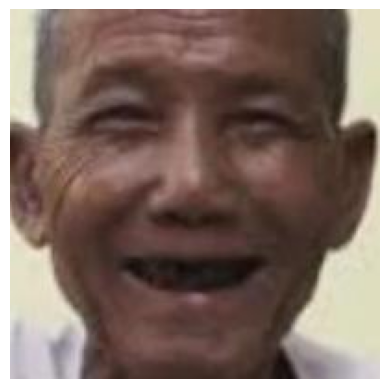

In [ ]:
from PIL import Image
img = Image.open(df['image'][0])
plt.axis('off')
plt.imshow(img);

<Axes: xlabel='age', ylabel='Density'>

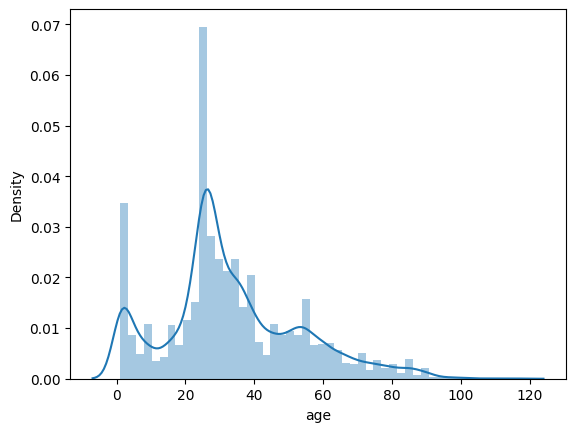

In [ ]:
sns.distplot(df['age'])

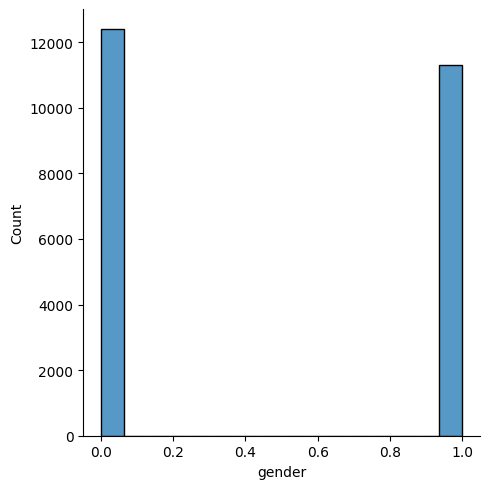

In [ ]:
sns.displot(df['gender'])

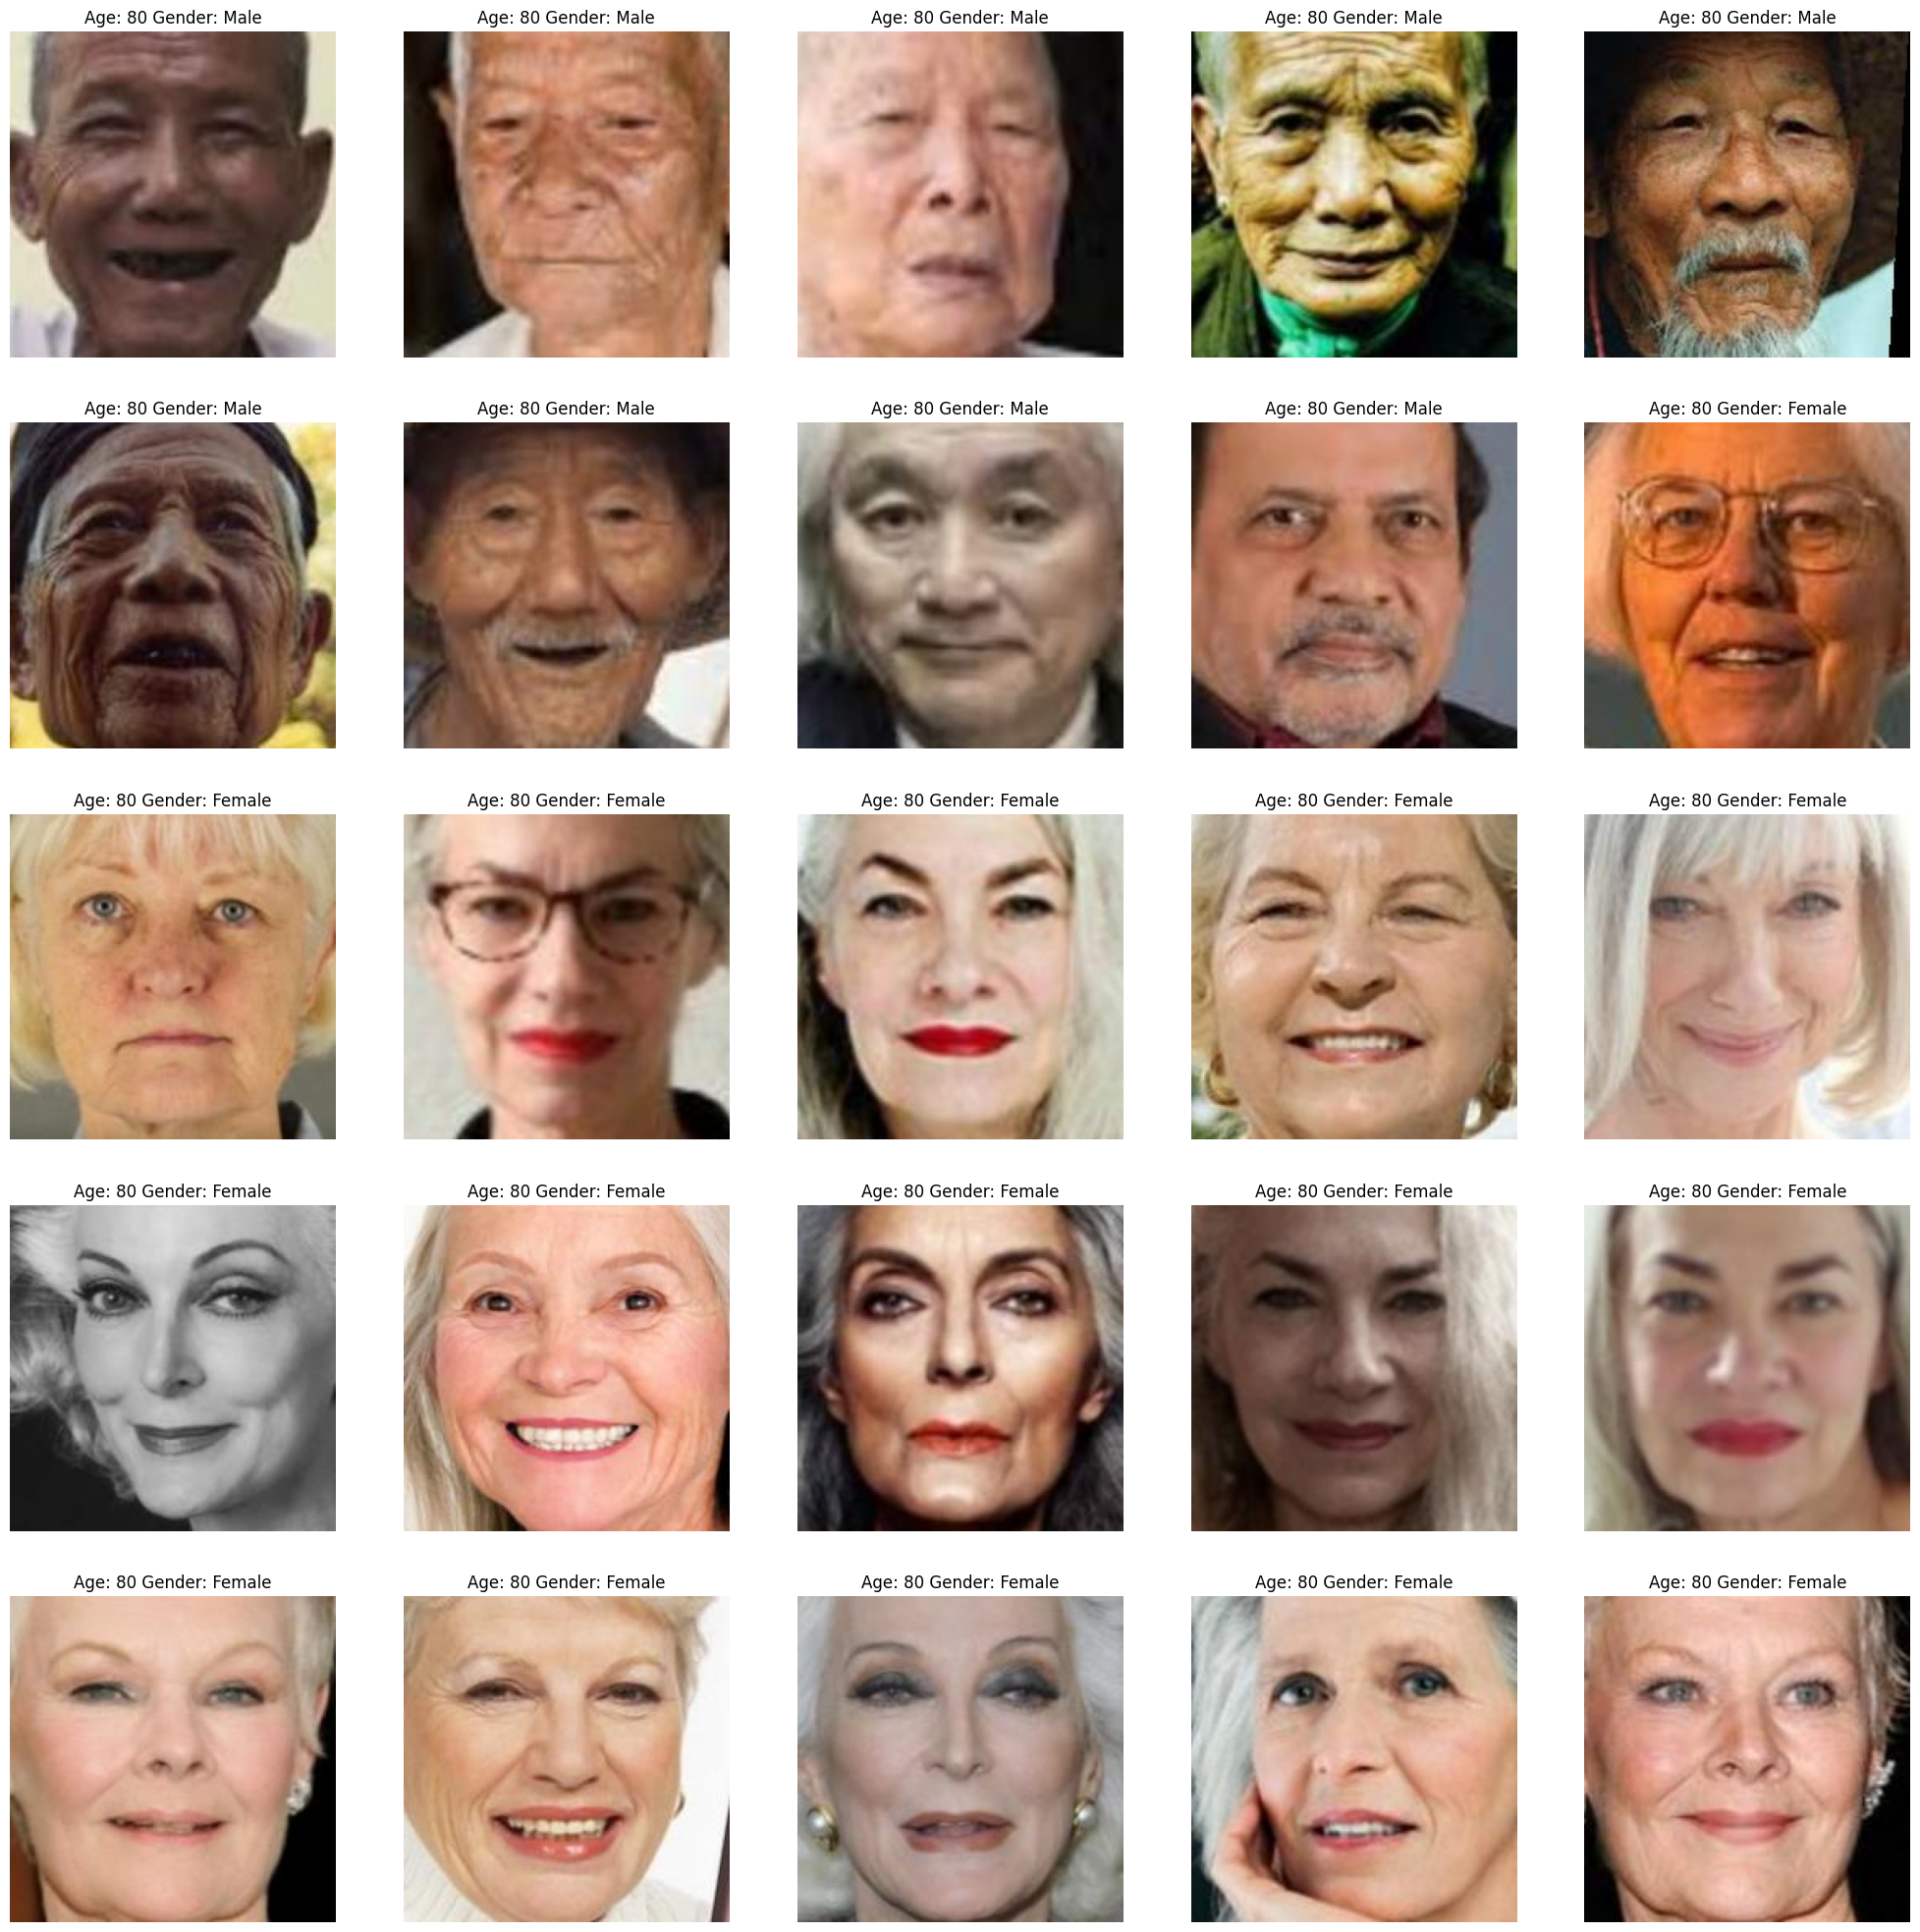

In [ ]:
plt.figure(figsize=(25, 25))
files = df.iloc[0:25]
for index, file, age, gender in files.itertuples():
    plt.subplot(5, 5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(f"Age: {age} Gender: {gender_dict[gender]}")
    plt.axis('off')

In [ ]:
from keras.preprocessing.image import load_img
import numpy as np
from tqdm import tqdm
from PIL import Image

def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, color_mode='grayscale')  # Load the image in grayscale
        img = img.resize((128, 128), Image.ANTIALIAS)
        img = np.array(img)
        features.append(img)

    features = np.array(features)

    # Reshape if using grayscale images (1 channel)
    features = features.reshape(len(features), 128, 128, 1)
    return features

# Assuming df['image'] contains the paths to your images
X = extract_features(df['image'])


100%|██████████| 23708/23708 [2:25:48<00:00,  2.71it/s]


In [ ]:
X.shape

(23708, 128, 128, 1)

In [ ]:
X = X/255.0

In [ ]:
np.save('X.npy', X)

In [ ]:
y_gender = np.array(df['gender'])
y_age = np.array(df['age'])

In [ ]:
np.save('y_gender.npy', y_gender)
np.save('y_age.npy', y_age)

In [ ]:
input_shape = (128,128,1)


In [ ]:
#Building model
inputs = Input((input_shape))
#convolutional layers
conv_1 =  Conv2D(32, kernel_size=(3, 3), activation = 'relu') (inputs)
maxp_1 = MaxPooling2D(pool_size=(2, 2)) (conv_1)
conv_2 = Conv2D(64, kernel_size=(3, 3), activation = 'relu') (maxp_1)
maxp_2 = MaxPooling2D(pool_size=(2, 2)) (conv_2)
conv_3 = Conv2D(128, kernel_size=(3, 3), activation = 'relu') (maxp_2)
maxp_3 = MaxPooling2D(pool_size=(2, 2)) (conv_3)
conv_4 = Conv2D(256, kernel_size=(3, 3), activation = 'relu') (maxp_3)
maxp_4 = MaxPooling2D(pool_size=(2, 2)) (conv_4)
flatten = Flatten() (maxp_4)
#fully connected layers
dense_1 = Dense (256, activation = 'relu') (flatten)
dense_2 = Dense (256, activation='relu') (flatten)
dropout_1 = Dropout(0.3) (dense_1)
dropout_2 = Dropout (0.3) (dense_2)

output_1 = Dense (1, activation = 'sigmoid', name = 'gender_out') (dropout_1)
output_2 = Dense(1, activation = 'relu', name='age_out') (dropout_2)

model = Model(inputs=[inputs], outputs=[output_1, output_2])
model.compile(loss=['binary_crossentropy', 'mae'], optimizer='adam', metrics=[['accuracy'], ['mae']])

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 126, 126, 32)   │            320 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 63, 63, 32)     │              0 │ conv2d[0][0]           │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 61, 61, 64)     │         18,496 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 30, 30, 64)     │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 28, 28, 128)    │         73,856 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 14, 14, 128)    │              0 │ conv2d_2[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 12, 12, 256)    │        295,168 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 6, 6, 256)      │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 9216)           │              0 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 256)            │      2,359,552 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 256)            │      2,359,552 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 256)            │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 256)            │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gender_out (Dense)        │ (None, 1)              │            257 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ age_out (Dense)           │ (None, 1)              │            257 │ dropout_1[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 5,107,458 (19.48 MB)

 Trainable params: 5,107,458 (19.48 MB)

 Non-trainable params: 0 (0.00 B)

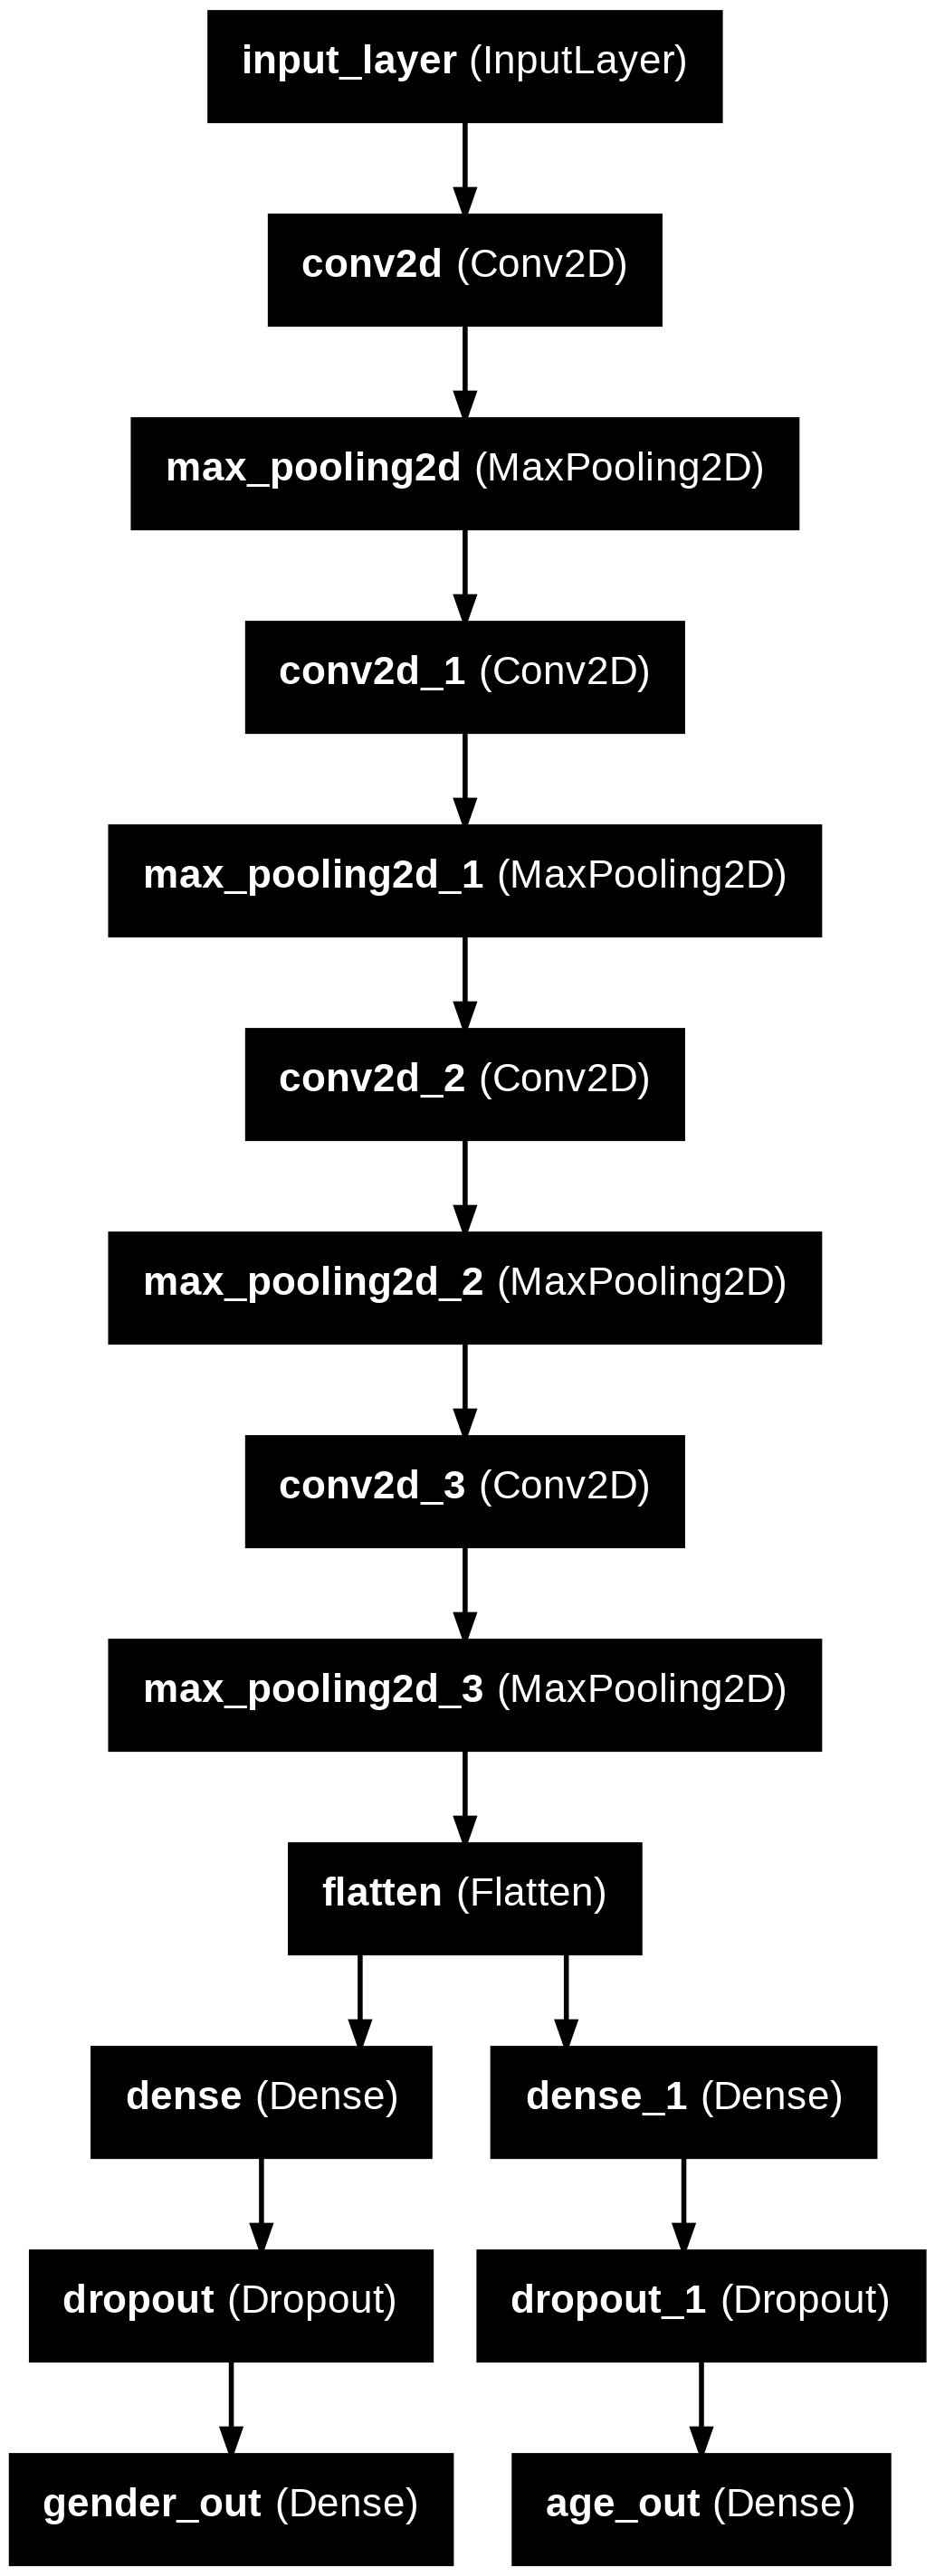

In [ ]:
from keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_layer_names=True)


In [ ]:
#train model
history = model.fit(x=X, y=[y_gender, y_age], batch_size=64, epochs=30, validation_split=0.2)

Epoch 1/30
297/297 ━━━━━━━━━━━━━━━━━━━━ 30s 68ms/step - age_out_mae: 16.9166 - gender_out_accuracy: 0.5417 - loss: 17.6262 - val_age_out_mae: 14.3234 - val_gender_out_accuracy: 0.4407 - val_loss: 15.0206
Epoch 2/30
297/297 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - age_out_mae: 13.7218 - gender_out_accuracy: 0.6235 - loss: 14.3582 - val_age_out_mae: 19.6108 - val_gender_out_accuracy: 0.6617 - val_loss: 20.2194
Epoch 3/30
297/297 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - age_out_mae: 11.8233 - gender_out_accuracy: 0.7687 - loss: 12.3196 - val_age_out_mae: 13.3509 - val_gender_out_accuracy: 0.6915 - val_loss: 13.8994
Epoch 4/30
297/297 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - age_out_mae: 10.2106 - gender_out_accuracy: 0.8074 - loss: 10.6490 - val_age_out_mae: 6.9066 - val_gender_out_accuracy: 0.6938 - val_loss: 7.4511
Epoch 5/30
297/297 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - age_out_mae: 9.4252 - gender_out_accuracy: 0.8237 - loss: 9.8280 - val_age_out_mae: 12.5465 - val_gender_out_accuracy: 0.7484 - va

In [ ]:
# Save the model to a file
model.save('age_gender_model1.h5')


In [ ]:
# Save only the model weights
model.save_weights('age_gender_model_weights1.weights.h5')



In [ ]:
# Evaluate the model
evaluation = model.evaluate(x=X, y=[y_gender, y_age], batch_size=64)

# Print the evaluation results
print("Total Loss:", evaluation[0])
print("Gender Output - Accuracy:", evaluation[2])
print("Age Output - MAE:", evaluation[1])



371/371 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - age_out_mae: 4.0869 - gender_out_accuracy: 0.9672 - loss: 4.1808
Total Loss: 4.444524765014648
Gender Output - Accuracy: 0.9398937225341797
Age Output - MAE: 4.282380104064941


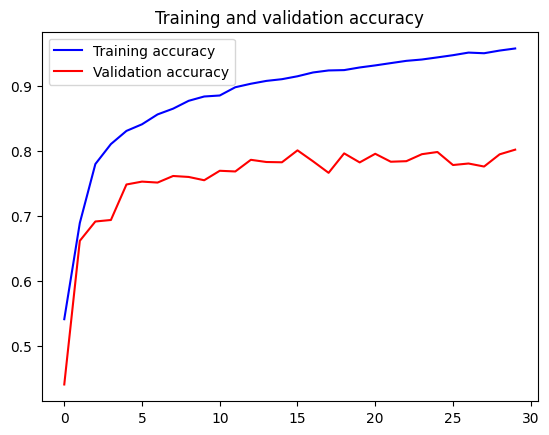

<Figure size 640x480 with 0 Axes>

In [ ]:
acc = history.history['gender_out_accuracy']
val_acc = history.history['val_gender_out_accuracy']
epochs = range(len(acc))
plt.plot(epochs, acc, 'b',label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

# loss = history.history['loss']
# val_loss = history.history['val_loss']
# plt.plot(epochs, loss, 'b', label='Training loss')
# plt.plot(epochs, val_loss, 'r', label='Validation loss')
# plt.title('Training and validation loss')
# plt.legend()
# plt.figure()

plt.show()

Original Gender: Female Original Age: 85
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 707ms/step
Predicted Gender: Female Predicted Age: 96


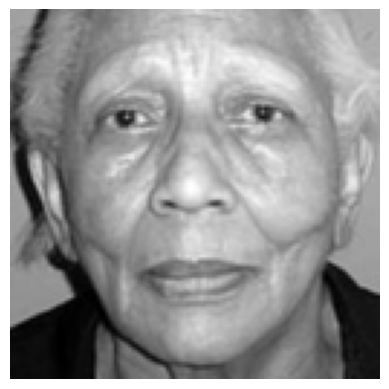

In [ ]:
image_index=300
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])

#predict from model

pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]

pred_age = round(pred[1][0][0])

print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap= 'gray');

Original Gender: Female Original Age: 85
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Predicted Gender: Female Predicted Age: 84


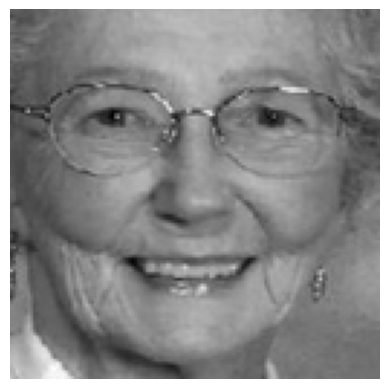

In [ ]:
image_index=250
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])

#predict from model

pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]

pred_age = round(pred[1][0][0])

print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap= 'gray');

Original Gender: Male Original Age: 80
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Predicted Gender: Male Predicted Age: 65


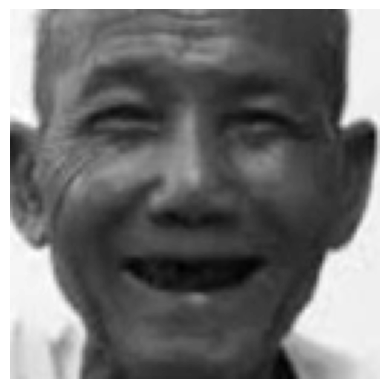

In [ ]:
image_index=0
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])

#predict from model

pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]

pred_age = round(pred[1][0][0])

print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap= 'gray');

Original Gender: Female Original Age: 6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Predicted Gender: Female Predicted Age: 6


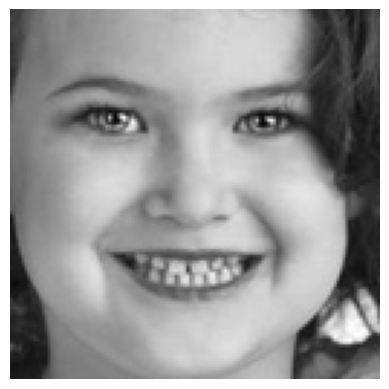

In [ ]:
image_index=1000
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])

#predict from model

pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]

pred_age = round(pred[1][0][0])

print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap= 'gray');

Original Gender: Male Original Age: 85
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Predicted Gender: Male Predicted Age: 85


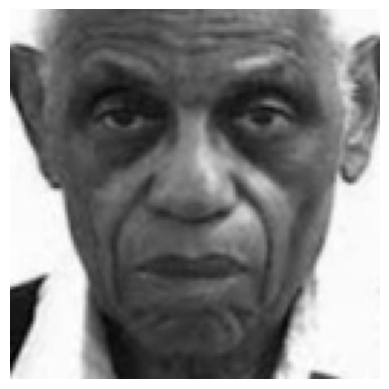

In [ ]:
image_index=200
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])

#predict from model

pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]

pred_age = round(pred[1][0][0])

print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap= 'gray');

Original Gender: Female Original Age: 95
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Predicted Gender: Female Predicted Age: 92


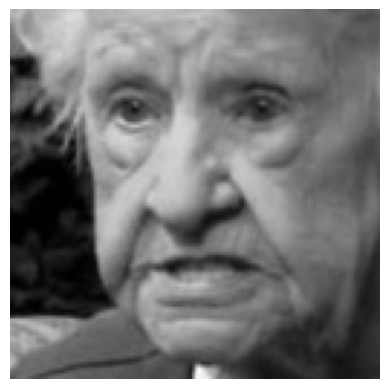

In [ ]:
image_index=800
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])

#predict from model

pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]

pred_age = round(pred[1][0][0])

print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap= 'gray');

Original Gender: Male Original Age: 9
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Predicted Gender: Male Predicted Age: 9


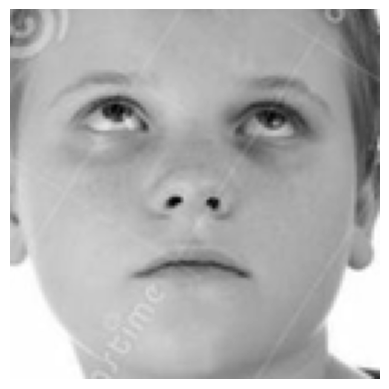

In [ ]:
image_index=900
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])

#predict from model

pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]

pred_age = round(pred[1][0][0])

print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap= 'gray');

Original Gender: Male Original Age: 58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Predicted Gender: Male Predicted Age: 61


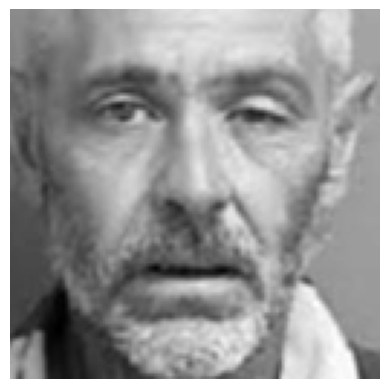

In [ ]:
image_index=3200
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])

#predict from model

pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]

pred_age = round(pred[1][0][0])

print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap= 'gray');

Original Gender: Male Original Age: 80
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Predicted Gender: Male Predicted Age: 65


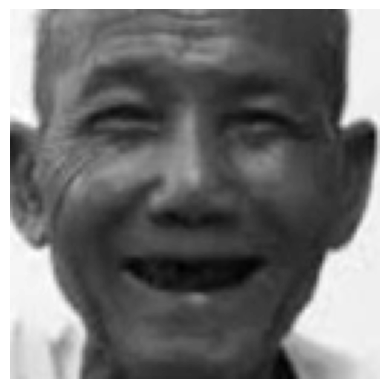

In [ ]:
image_index=0
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])

#predict from model

pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]

pred_age = round(pred[1][0][0])

print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap= 'gray');

Original Gender: Male Original Age: 80
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Predicted Gender: Male Predicted Age: 83


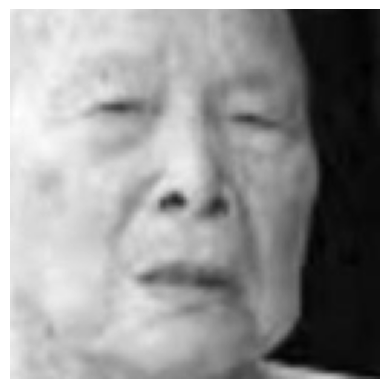

In [ ]:
image_index=2
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])

#predict from model

pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]

pred_age = round(pred[1][0][0])

print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap= 'gray');